In [97]:
#EDA
%matplotlib inline
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
import io
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from textblob import TextBlob, Word
import json
import os
from os.path import basename
from sklearn import preprocessing
from __future__ import division, unicode_literals
from scipy.cluster.hierarchy import fcluster

#Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#Misc
import warnings
warnings.filterwarnings('ignore')

In [14]:
def makeFString(title):
    return base + title + '.txt'

def makeFExtString(title, ext):
    return base + title + ext

def openFile(fName):
    with open(fName) as dFile:    
        data = json.load(dFile)
    return data

def saveData(nFile, data):
    target = open(nFile, 'w')
    target.write(data)
    target.close()
    return target

def pullTerm(data, term):
    comp = []
    for x in data:
        if term in x:
            comp += [x[term]]
    return comp
    
def analyze(bag):
    return analyzeCoSim(analyzeVectorizer(bag, 0.70, 0.05))

def analyzeVectorizer(bag, max_df, min_df):
    tfidf_vectorizer = TfidfVectorizer(max_df = max_df, min_df = min_df)
    return tfidf_vectorizer.fit_transform(bag)

def analyzeCoSim(bag):
    sim = []
    for x, matx in enumerate(bag):
        cos_sim = cosine_similarity(matx, bag)
        sim += cos_sim.tolist()
    return sim

In [3]:
def get_files(path):
    for (dirpath, _, filenames) in os.walk(path):
        for filename in filenames:
            yield os.path.join(dirpath, filename)
 
def getFilename(fPath):
    return basename(fPath).rsplit('.', 1)[0]

def findExtMissing(fName, ext):
    filename, file_extension = os.path.splitext(fName)
    if os.path.exists(filename + '(analysis)' + ext):
        return False
    return True

def getMissingBooks():
    files = []
    for filename in get_files('./test_assets/'):
        if '.txt' in filename and findExtMissing(filename,'.json'):
            files += [filename]
    return files

def getBooks():
    files = []
    for filename in get_files('./test_assets/'):
        if '.json' in filename:
            files += [filename]
    return files

In [4]:
def scaleIgnoreFirst(data):
    construct = []
    cols = data.columns.values
    for col in cols:
        sorted_col = pd.DataFrame(data[col])
        first = sorted_col.nlargest(2, col).iloc[0]
        second = sorted_col.nlargest(2, col).iloc[1]
        sorted_col.loc[sorted_col[col] == first[col], col] = second[col]
        construct += [sorted_col]
    new_df = pd.concat(construct, axis=1)
    return new_df

def returnNormCS(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    scaled = scaleIgnoreFirst(df)
    df_phrase_scaled = min_max_scaler.fit_transform(scaled)
    df_normalized = pd.DataFrame(df_phrase_scaled)
    return df_normalized

In [5]:
# print getMissingBooks()

In [6]:
# print getBooks()

In [7]:
titles = getBooks()
datum = []

for title in titles:
#     base = basename(title).rsplit('.', 1)[0]
    
    data = openFile(title)
#     data['author'] = base.split(',')[0]
#     data['title'] = base.replace(base.split(',')[0] + ", ","").replace("(analysis)","")
    datum += [data]

In [8]:
df_words = pd.DataFrame(analyze(pullTerm(datum,'words')))
# df_phrases = pd.DataFrame(analyze(pullTerm(datum,'phrases')))
df_sentiment = pd.DataFrame(analyze(pullTerm(datum,'sentiment')))

In [9]:
# norm_cs_phrases = returnNormCS(df_phrases)
norm_cs_words = returnNormCS(df_words)
norm_cs_sentiment = returnNormCS(df_sentiment)

In [10]:
metas = [[x['words'], x['polarity'], x['subjectivity']] for x in pullTerm(datum,'meta')]
norm_cs_meta = returnNormCS(pd.DataFrame(analyzeCoSim(metas)))
# norm_cs_meta

In [2]:
google_metas = []
for x in pullTerm(datum,'meta'):
    info = {}
    x_goog = x['google']
    if 'title' in x_goog:
        info['title'] = x_goog['title']
    else:
        info['title'] = None
    if 'authors' in x_goog:
        info['authors'] = ', '.join(x_goog['authors'])
    else:
        info['authors'] = None
    if 'categories' in x_goog:
        info['categories'] = ' '.join(x_goog['categories'])
    else:
        info['categories'] = None
    google_metas += [info]

g_meta_df = pd.DataFrame(google_metas)
g_meta_df.head()

NameError: name 'pullTerm' is not defined

In [1]:
top = g_meta_df['categories'].value_counts().index.tolist()[0]
fiction = g_meta_df.ix[(g_meta_df['categories']==top)]
fiction.head()

NameError: name 'g_meta_df' is not defined

In [93]:
indices = g_meta_df.ix[(g_meta_df['categories']==top)].index.tolist()
word_temp = pd.DataFrame(pullTerm(datum,'words'))
#print word_temp.iloc[indices,:][0]
vectorized_words = analyzeVectorizer(word_temp.iloc[indices,:][0], .7, .05)
# # df_words = pd.DataFrame(analyzeVectorizer(pullTerm(datum,'words'), .7, .05))

In [75]:
fiction_slice_pca = []
pca = PCA(n_components=2)
pca_fiction = pca.fit_transform(df_words.iloc[indices,:])

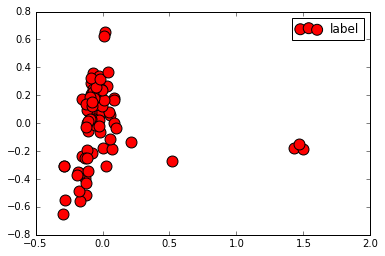

In [70]:
pca_df = pd.DataFrame(pca_fiction, columns=['x','y'])
plt.scatter(pca_df['x'], pca_df['y'], s=120, c='r', label=str('label'))
plt.legend()

In [72]:
meta_fiction = fiction.reset_index()
for idx, x in meta_fiction.iterrows():
    print x['authors'] + ": " + x['title'] 
    print "(" , round(pca_df.iloc[idx]['x'],2) , "," , round(pca_df.iloc[idx]['y'],2) , ")"

Abigail Roux: Ball & Chain
( -0.05 , 0.32 )
Adite Banerjie: The Indian Tycoon's Marriage Deal
( 0.02 , -0.31 )
Aharon Appelfeld: Suddenly, Love
( -0.07 , 0.32 )
Alan Dean Foster: The Force Awakens
( -0.11 , -0.05 )
Alannah Carbonneau: The Curse of Bound Blood
( 1.43 , -0.18 )
Alannah Carbonneau: The Curse of Bound Blood
( 1.5 , -0.18 )
Alannah Carbonneau: The Curse of Bound Blood
( 1.46 , -0.15 )
Alex Irvine: Dawn of the Planet of the Apes: The Official Movie Novelization
( -0.16 , 0.17 )
Alexander McCall Smith: Fatty O'Leary's Dinner Party
( -0.07 , 0.36 )
Alexander McCall Smith: Sunshine on Scotland Street
( -0.09 , 0.21 )
Alexandra Christian: One Hundred Strokes
( 0.08 , 0.18 )
Alexia Purdy: Amplified (Reign of Blood #3)
( -0.03 , 0.06 )
Lindsay Townsend: A Knight's Vow
( 0.09 , 0.17 )
Allyson K Abbott: Murder with a Twist
( -0.08 , 0.19 )
Robyn Donald: Ruthless Billionaire, Inexperienced Mistress
( 0.05 , 0.06 )
Amanda Forester: The Trouble with a Highland Bride
( -0.09 , 0.08 )
An

In [94]:
X = vectorized_words.todense()
Z = linkage(X, 'ward')
c, coph_dists = cophenet(Z, pdist(X))
c

0.31367554104454076

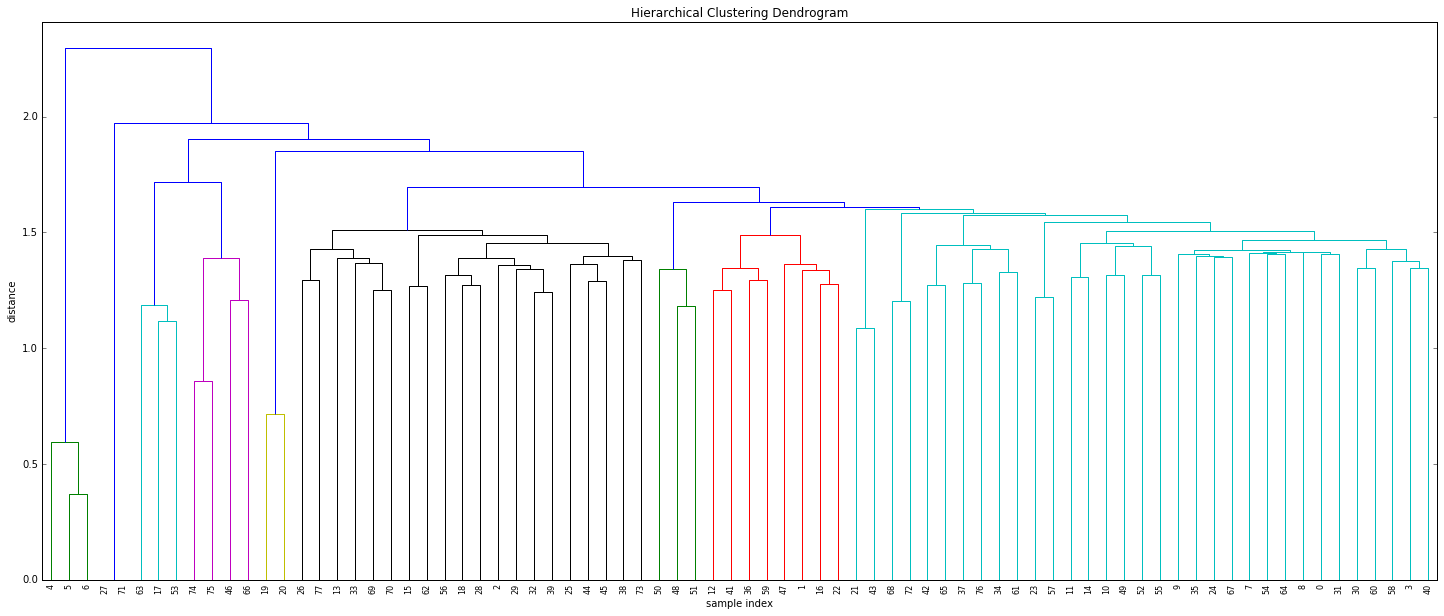

In [96]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [107]:
max_d = 1.6
clusters = fcluster(Z, max_d, criterion='distance')
for idx, x in meta_fiction.iterrows():
    print "(" + str(idx) + "," + str(clusters[idx]) + ") " + x['authors'] + ": " + x['title']

(0,10) Abigail Roux: Ball & Chain
(1,8) Adite Banerjie: The Indian Tycoon's Marriage Deal
(2,6) Aharon Appelfeld: Suddenly, Love
(3,10) Alan Dean Foster: The Force Awakens
(4,1) Alannah Carbonneau: The Curse of Bound Blood
(5,1) Alannah Carbonneau: The Curse of Bound Blood
(6,1) Alannah Carbonneau: The Curse of Bound Blood
(7,10) Alex Irvine: Dawn of the Planet of the Apes: The Official Movie Novelization
(8,10) Alexander McCall Smith: Fatty O'Leary's Dinner Party
(9,10) Alexander McCall Smith: Sunshine on Scotland Street
(10,10) Alexandra Christian: One Hundred Strokes
(11,10) Alexia Purdy: Amplified (Reign of Blood #3)
(12,8) Lindsay Townsend: A Knight's Vow
(13,6) Allyson K Abbott: Murder with a Twist
(14,10) Robyn Donald: Ruthless Billionaire, Inexperienced Mistress
(15,6) Amanda Forester: The Trouble with a Highland Bride
(16,8) Andre Norton, Patricia Mathews, Sasha Miller: On Wings of Magic
(17,3) Andy Gavin: Untimed
(18,6) Anna Schmidt: A Sister's Forgiveness
(19,5) Ruth Cardell

In [ ]:
X = book1_finished.drop('cat',axis=1)

X = analyzeVectorizer(bag, max_df, min_df)

pca = PCA(n_components=2)
pca1 = pca.fit_transform(X)

X = book2_finished.drop('cat',axis=1)
pca2 = pca.fit_transform(X)
X = book3_finished.drop('cat',axis=1)
pca3 = pca.fit_transform(X)



In [724]:
#weights = [96,0,2,2]
weights = [6,1,4]
df_all = ((norm_cs_words * weights[0]) + (norm_cs_sentiment * weights[1]) + (norm_cs_meta * weights[2])) / np.sum(weights)  

In [725]:
def determineCloseness(pos, data, spots):
    datay = data.sort([pos],ascending=[0]).index
    print "Book: " + getFilename(getBooks()[pos].replace("(analysis)",""))
    for idx, x in enumerate(datay[:spots]):
        if (x != pos):
            print str(idx) + ":" + str(x) + " - "+ getFilename(getBooks()[x].replace("(analysis)","")) + " (" + str(round(data[pos][x],2)) + ")"
        
determineCloseness(74, df_all, 15)

Book: James S.A. Corey, Babylon's Ashes
1:125 - Ron Francis, Deep Space Endeavor - Death Match (0.75)
2:4 - Alan Foster, Star Wars - The Force Awakens (0.72)
3:42 - Brian Kilmeade, Thomas Jefferson and the Tripoli Pirates (0.69)
4:73 - James Patterson, Cross the Line by (0.68)
5:126 - Ron Francis, Deep Space Endeavor - Total Betrayal (0.66)
6:103 - M. Donice Byrd, An Officer but No Gentleman (0.63)
7:143 - Yuval Noah Harari, Sapiens - A Brief History of Humankind (0.61)
8:81 - John Jacob Astor, Astoria (0.6)
9:135 - Steven Levitt, When to Rob a Bank (0.59)
10:63 - Gary Shteyngart, Absurdistan - A Novel (0.58)
11:22 - Andi Dorfman, It's Not Okay - Turning Heartbreak into Happily Never After (0.58)
12:110 - Michele Barrow, Fire and Ice (0.57)
13:98 - Lee Child, Night School (0.55)
14:21 - Amy Schumer, The Girl with the Lower Back Tattoo (0.54)


In [818]:
# from __future__ import division, unicode_literals
# import math

# def tf(word, blob):
#     return blob.words.count(word) / len(blob.words)

# def n_containing(word, bloblist):
#     return sum(1 for blob in bloblist if word in blob.words)

# def idf(word, bloblist):
#     return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

# def tfidf(word, blob, bloblist):
#     return tf(word, blob) * idf(word, bloblist)

In [727]:
left = pullTerm([datum[42]],'words')[0]
right = pullTerm([datum[74]],'words')[0]
bloblist = [left,right]

tfidf_vectorizer = TfidfVectorizer(max_features=10)
matrix = tfidf_vectorizer.fit_transform(bloblist)
top_features = tfidf_vectorizer.vocabulary_
n = len(top_features)
print top_features

# insert the emoticons into the vocabulary of common features
#emoticons = {":)":0, ":P":1, ":(":2)}
#for feature, index in emoticons.items():
#    top_features[feature] = n + index

# re-vectorize using both sets of features
# at this point len(top_features) == 13
#vect = TfidfVectorizer(vocabulary=top_features)
#matrix = vect.fit_transform(traindata)

{u'to': 8, u'wa': 9, u'the': 7, u'that': 6, u'he': 1, u'it': 4, u'in': 3, u'and': 0, u'of': 5, u'his': 2}


In [808]:
#Find the most frequently occuring word in the first file that is also present in all the other documents
from sklearn.feature_extraction import text 

my_stops = ['said','just','did','going','wa','let']

stop_words = text.ENGLISH_STOP_WORDS.union(my_stops)

left = pullTerm(datum[70:75],'words')
lectures = left
vectorizer = TfidfVectorizer(stop_words=stop_words)
X = vectorizer.fit_transform(lectures)
indices = np.argsort(vectorizer.idf_)
# print len(indices)
features = vectorizer.get_feature_names()
top_n = 100
top_features = [(features[i],vectorizer.idf_[i]) for i in indices[:top_n]]
# print top_features

In [809]:
import operator

check = TextBlob(pullTerm([datum[74]],'words')[0])
x = check.word_counts
sorted_x = sorted(x.items(), key=operator.itemgetter(1))[::-1]

joined_features = [features[i] for i in indices if vectorizer.idf_[i] == 1]
top = []
maxTop = 50

for x in sorted_x:
    if x[0] in joined_features:
        top += [x]
    if len(top) > maxTop:
        break

print top
# for x in top_features:
#     print check.

[(u'like', 823), (u'know', 347), (u'time', 333), (u'little', 329), (u'way', 328), (u'station', 327), (u'hand', 307), (u'free', 302), (u'thing', 289), (u'eye', 269), (u'right', 249), (u'looked', 217), (u'voice', 207), (u'came', 203), (u'away', 200), (u'got', 198), (u'felt', 198), (u'maybe', 196), (u'long', 195), (u'make', 189), (u'come', 187), (u'man', 181), (u'took', 179), (u'good', 174), (u'need', 169), (u'head', 165), (u'belt', 163), (u'asked', 156), (u'think', 153), (u'left', 153), (u'moment', 151), (u'went', 151), (u'new', 144), (u'hard', 139), (u'thought', 137), (u'place', 134), (u'gate', 134), (u'room', 134), (u'say', 134), (u'looking', 133), (u'knew', 133), (u'want', 131), (u'look', 122), (u'coming', 117), (u'work', 115), (u'turned', 115), (u'light', 111), (u'meant', 111), (u'second', 111), (u'arm', 107), (u'life', 107)]


In [810]:
for x in pullTerm(datum[40:43],'words'):
    check = TextBlob(x)
    print check.words.count('like')

106
115
30


In [817]:
test = pullTerm([datum[74]],'words')[0]

vectorizer2 = TfidfVectorizer(stop_words=stop_words)
X = vectorizer2.fit_transform([test])
indices = np.argsort(vectorizer.idf_)[::-1]
# print len(indices)
features = vectorizer.get_feature_names()
top_n = 50
top_features = [(features[i],vectorizer.idf_[i]) for i in indices[:top_n]]
print top_features

[(u'\xf6l\xfcm', 2.09861228866811), (u'impervious', 2.09861228866811), (u'imported', 2.09861228866811), (u'importance', 2.09861228866811), (u'import', 2.09861228866811), (u'imploring', 2.09861228866811), (u'implication', 2.09861228866811), (u'implicated', 2.09861228866811), (u'implausible', 2.09861228866811), (u'implacably', 2.09861228866811), (u'impinges', 2.09861228866811), (u'impinge', 2.09861228866811), (u'impersonating', 2.09861228866811), (u'impala', 2.09861228866811), (u'impersonal', 2.09861228866811), (u'imperious', 2.09861228866811), (u'imperial', 2.09861228866811), (u'imperfect', 2.09861228866811), (u'imperceptibly', 2.09861228866811), (u'impenetrable', 2.09861228866811), (u'impeding', 2.09861228866811), (u'impatience', 2.09861228866811), (u'impassively', 2.09861228866811), (u'impassive', 2.09861228866811), (u'importunate', 2.09861228866811), (u'impose', 2.09861228866811), (u'imposed', 2.09861228866811), (u'impossibly', 2.09861228866811), (u'inattentive', 2.09861228866811), (

In [639]:
list = pd.DataFrame([getFilename(x.replace("(analysis)","")) for x in getBooks()], columns=["Name"])

In [640]:
def searchLibrary(search):
    return list[list["Name"].str.contains(search)]
    
print searchLibrary("Arabella Rose")

                                                 Name
30  Arabella Rose, Amber Woods Shifters - Alpha Scent
31  Arabella Rose, Amber Woods Shifters- Connor's ...


In [396]:
# df_all.ix[20:75,20:75]

In [397]:
# df_words.ix[30:40,30:40]

In [658]:
datum[74]["meta"]

{u'polarity': 0.03946466479855605,
 u'subjectivity': 0.294323930307046,
 u'words': 15}

In [659]:
datum[125]["meta"]

{u'polarity': 0.07184056441576696,
 u'subjectivity': 0.34168448607166413,
 u'words': 17}

In [660]:
datum[4]["meta"]

{u'polarity': 0.03141829918861733,
 u'subjectivity': 0.3079727483690307,
 u'words': 13}

In [661]:
norm_cs_meta[74]

0      0.647983
1      0.933421
2      0.975821
3      0.930495
4      0.869028
5      0.000000
6      0.442429
7      0.655724
8      0.999727
9      0.987513
10     0.907493
11     0.967929
12     0.942868
13     0.957510
14     0.933259
15     0.889239
16     0.957340
17     0.936240
18     0.989036
19     0.907321
20     0.986546
21     0.974299
22     0.982943
23     0.983675
24     0.668571
25     0.715307
26     0.697433
27     0.939252
28     0.995078
29     0.996032
         ...   
114    0.908171
115    0.920621
116    0.880936
117    0.940396
118    0.592520
119    0.915041
120    0.989034
121    0.869600
122    0.964957
123    0.927570
124    0.495683
125    0.978241
126    0.825416
127    0.917046
128    0.451729
129    0.984355
130    0.852404
131    0.758249
132    0.863752
133    0.872813
134    0.982079
135    0.944763
136    0.300111
137    0.863742
138    0.895831
139    0.704870
140    0.920245
141    0.972930
142    0.974510
143    0.967034
Name: 74, dtype: float64